# Use the scattering transforms to build a Classification Model（散射网络进阶）

在上个实验中（assignment_1），我们学习了什么是小波散射变换，并对其有了一个初步的认识（hope so...）, 但是在实际的使用中肯定不是用上个实验中那么简单的模型了，总之，在这里我们使用散射网络来搭建一个分类模型（基于Fashion-MNIST数据集，至于为啥不用大一点的，可以参考下面的注释QAQ）。

This notebook is about classification. You will:

- using the scattering transforms to bulid a **deep convolution Net**
- use the model above to do classification on Fashion-MNIST


*Note here, given that U may not be able to use a GPU to accelerate the train process , here our example is based on the Fashion-MNIST datasets, hope that it will works well for U, good luck!*

In [1]:
# 下面这行命令可能不是必须的！！!
# 如果你的 Notebook 老是挂掉然后重启的话可能这行命令是有用的~
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# 首先，平平无奇的加载一些库
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torchvision import datasets, transforms
from kymatio.torch import Scattering2D
import argparse

In [3]:
## 测试能否使用 GPU 加速
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
# 然后，获取数据集
train_set = datasets.FashionMNIST(root='.data', train=True,
                                  transform=transforms.ToTensor(),
                                  download=True)
test_set = datasets.FashionMNIST(root='.data', train=False,
                                 transform=transforms.ToTensor(),
                               download=True)

## Need you to implement the follow function !!!

回顾一下，假设我们输入是一张二维的灰度图像，它的大小是（B,C,H,W）,B代表batch-size,C代表通道数（RGB图像为3，灰度图像为1），HxW代表图像的分辨率了，那么散射网络的输出大小应当是 

$$ (B,C,\frac{1+LJ+L^{2}J(J-1)}{2},\frac{H}{2^J},\frac{W}{2^J} )$$

请根据该关系完成下面的函数！！

In [5]:
def get_scatter_transform(device):
    shape = (28, 28, 1)
    scattering = Scattering2D(J=2, shape=shape[:2]).to(device)
    K = None
    (h, w) = shape[:2]
    ##############################################################################
    # TODO: This function is to get the scattring transform obeject and return   #
    #        the channels(represented by 'K') after scatting transform, please   #
    #        implemrnt this fucntion according to the relationship above.        #
    # Note the type of h and w is int                                            #
    ##############################################################################
    K = 81 * 1
    (h, w) = (h//4, w//4)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return scattering, K, (h, w)

## Bulid our mode

接下来我们需要创建一个类我们建立一个简单的分类模型（只有两个卷积层，不过对于FMNIST这种大小的数据集也够了~）

这个模型的结构如下：

```python
Scattering2dCNN(
  (bn): BatchNorm2d(81, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (features): Sequential(
    (0): Conv2d(81, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)
```

注意到在如上的模型种我们并没有将散射变换集成到我们的模型之中（这当然也是可以的~），但是由于散射网络并不需要学习，所以这两种方式其实区别不大

anyway, 这里需要你把上面这个模型实现出来QAQ!


In [6]:
class Scattering2dCNN(nn.Module):
    '''
        Simple CNN model with features extrated bu ScatNet
    '''
    def __init__(self, in_channels):
        super(Scattering2dCNN, self).__init__()
        self.in_channels = in_channels
        
        self.bn = None
        self.features = None
        self.classifier = None
        
        self.build()

    def build(self):
        ##############################################################################
        # TODO:  implement the build function to realize a model showed above        #
        ##############################################################################
        self.bn = nn.BatchNorm2d(self.in_channels)
        layers = []
        c = self.in_channels
        
        ch1, ch2 = (32, 64)
        cfg = [(ch1, 3, 2, 1), (ch2, 3, 1, 1)]
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=1)]
            else:
                filters, k_size, stride, pad = v
                conv2d = nn.Conv2d(c, filters, kernel_size=k_size, stride=stride, padding=pad)
                layers += [conv2d, nn.ReLU(inplace=True)]
                c = filters

        self.features = nn.Sequential(*layers)
        
        hidden = 32
        self.classifier = nn.Sequential(nn.Linear(c * 4 * 4, hidden),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(hidden, 10))
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        

    def forward(self, x):
        x = self.bn(x.view(-1, self.in_channels, 7, 7))
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## It's your job to finish the train process

请将训练过程补充完整，如果实在不会的话，可以参考下面的 test 函数~~~

In [7]:
# the function of train process
def train(model, device, train_loader, optimizer, epoch, scattering):
    
    model.train()
    
    num_examples = 0
    correct = 0
    train_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        output = None
        loss = None
        ##############################################################################
        # TODO:  implement the train process                                        #
        # Note the the overall process is:                                          #
        #             input-> scattering transform -> CNN -> output                 #
        # Hint: the loss function could be Cross entropy loss function              #
        ##############################################################################
        optimizer.zero_grad()
        output = model(scattering(data))
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss += F.cross_entropy(output, target).item()
        num_examples += len(data)
            
    train_loss /= batch_idx
    train_acc = 100. * correct / num_examples
    
    print(f'Train set: Average loss: {train_loss:.4f}, '
            f'Accuracy: {correct}/{num_examples} ({train_acc:.2f}%)')
    
    return train_loss, train_acc

In [8]:
# the function of test process
def test(model, device, test_loader, scattering):
    model.eval()
    
    num_batchs = 0
    num_examples = 0
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(scattering(data))
            test_loss += F.cross_entropy(output, target).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            num_examples += len(data)
            num_batchs += 1

    test_loss /= num_batchs
    test_acc = 100. * correct / num_examples

    print(f'Test set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{num_examples} ({test_acc:.2f}%)')

    return test_loss, test_acc

## 现在开始我们的主函数


In [9]:
# 获取我们的散射网络的对象
scattering, K, _ = get_scatter_transform(device)

batch_size = 128

# DataLoaders
if use_cuda:
    num_workers = 4
    pin_memory = True
else:
    num_workers = None
    pin_memory = False
    
train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

# then load our model
model = Scattering2dCNN(K).to(device)

## 定义优化器
optimizer = torch.optim.Adam(model.parameters())

## 可以看看你建立的模型是啥个样子
print(model)

Scattering2dCNN(
  (bn): BatchNorm2d(81, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (features): Sequential(
    (0): Conv2d(81, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)


## 所以咱们这就开始训练了~~

考虑到大家可能在机房可能没有显卡，这个epoch就设置的比较小，当然这个也是小问题了, 大家可以根据实际情况自己修改~

In [10]:
train_loss_history = []
train_acc_history = []
test_acc_history = []
for epoch in range(0, 20):
    print(f"\nEpoch: {epoch}")
    trian_loss, train_acc = train(model, device, train_loader, optimizer, epoch+1, scattering)
    _, test_acc = test(model, device, test_loader, scattering)
    train_loss_history.append(trian_loss)
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)


Epoch: 0
Train set: Average loss: 0.4688, Accuracy: 49879/60000 (83.13%)
Test set: Average loss: 0.3197, Accuracy: 8827/10000 (88.27%)

Epoch: 1
Train set: Average loss: 0.2834, Accuracy: 53837/60000 (89.73%)
Test set: Average loss: 0.3029, Accuracy: 8887/10000 (88.87%)

Epoch: 2
Train set: Average loss: 0.2478, Accuracy: 54522/60000 (90.87%)
Test set: Average loss: 0.2570, Accuracy: 9043/10000 (90.43%)

Epoch: 3
Train set: Average loss: 0.2217, Accuracy: 55107/60000 (91.84%)
Test set: Average loss: 0.2530, Accuracy: 9045/10000 (90.45%)

Epoch: 4
Train set: Average loss: 0.2039, Accuracy: 55518/60000 (92.53%)
Test set: Average loss: 0.2498, Accuracy: 9099/10000 (90.99%)

Epoch: 5
Train set: Average loss: 0.1894, Accuracy: 55802/60000 (93.00%)
Test set: Average loss: 0.2528, Accuracy: 9084/10000 (90.84%)

Epoch: 6
Train set: Average loss: 0.1778, Accuracy: 56070/60000 (93.45%)
Test set: Average loss: 0.2307, Accuracy: 9160/10000 (91.60%)

Epoch: 7
Train set: Average loss: 0.1614, Accur

No handles with labels found to put in legend.


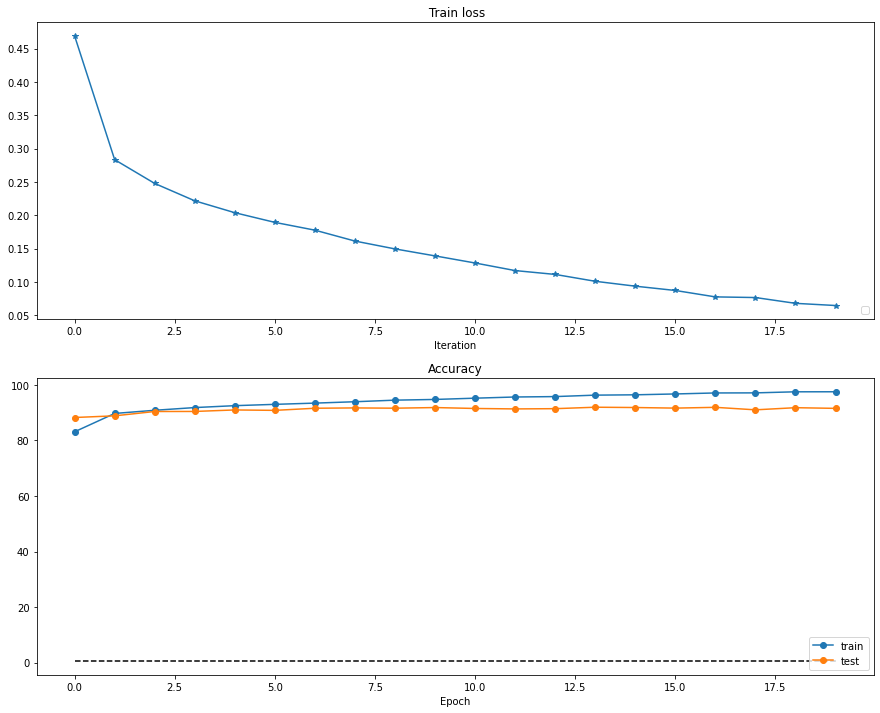

In [11]:
import matplotlib.pyplot as plt

# Run this cell to visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title(' Train loss')
plt.plot(train_loss_history, '-*')
plt.legend(loc='lower right')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(train_acc_history, '-o', label='train')
plt.plot(test_acc_history, '-o', label='test')
plt.plot([0.5] * len(test_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

## 到这里就结束了！！

首先按照惯例给出我的训练结果做一个参考：

![avatar](./images/assignment_2_1.png)

如果你一步步的做的话，我想得到类似的结果应该问题不大，其实若是你细致一些的话，你会发现其实跑几个Epoch模型就已经过拟合了，但是这并不是这里的重点，总之，到这里你已经对散射网络有了一个基本的了解了,希望这能对你有所帮助，再会~
